# **Costa Rica - Seizure and Homicide Data Analysis**
# v.1
#### InSight Crime - MAD Unit 
June, 2025


---------------------



### Introduction

Data:

1. **Intentional Homicides in Costa Rica (2010–2024)**
     
	Formatted data available [here](https://docs.google.com/spreadsheets/d/1-XG8sMyPwBXa6bdBCqqEPm2SrcHpKKn3YAHaBdyR-Lg/edit?gid=0#gid=0)  
	Source: [Intentional Homicides CR](https://drive.google.com/file/d/1cUswepSw-r3HLU6Be3duvjsRw329MoKg/view?ts=6841b341)
	
	Notes: There are some discrepancies in the population figures by year compared to the [INEC](https://services.inec.go.cr/proyeccionpoblacion/frmproyec.aspx) (at both national and provincial levels), but they do not affect the homicide rates per 100,000 inhabitants as reported in the source.

2. **Seizure data (2018-2024)**
   
	Source: [Control_de_la_Oferta_ODS_SW1 (Sheet "8")](https://docs.google.com/spreadsheets/d/1EhZ7hpFBpIFc375ByzMu1AIQrNnvw2FxIvXlxV5KE1E/edit?gid=661345260#gid=661345260) 

3. **Merged dataset**

	Available [here](https://github.com/FelipeVillota/costa-rica-presentation/tree/main/data/merged) 
	
	Notes: Dataframes were combined considering geographic disaggregation and time. Leaving us with country-level observations/indicators, by year, from 2018-2024. This is the starting point for the analysis


### Project Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/costa-rica-presentation](https://github.com/FelipeVillota/costa-rica-presentation)). I keep the repository `private` with the possibility to give collaborator-access to the online repo at any time. 

#### Reproducible Environment

In [123]:
# IMPORTANT

# In the Terminal, run the following commands to set up a virtual environment called `venv-cr`:
# python -m venv venv-cr

# To activate environment, run (the first is an optional, temporary auth) :
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass
# venv-cr\Scripts\activate

# Then select respective kernel 

# Update list master list
# pip freeze > requirements.txt

In [1]:
# Checking venv-db-watch works --> accept to install ipykernel package to connect to kernel if asked
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\costa-rica\costa-rica-presentation\venv-cr\Scripts\python.exe


#### Loading Libraries

In [2]:
# Install the required packages in the virtual environment:
# pip install --upgrade pip
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas
# pip install gspread gspread-formatting seaborn matplotlib missingno    

SyntaxError: invalid syntax (3835598099.py, line 2)

In [3]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
from io import BytesIO
from openpyxl import load_workbook


# pip freeze > requirements.txt

### Loading Data

In [4]:
# Both datasets are in the repository, so we can use raw GitHub URLs to access them directly.
# Use raw GitHub URLs
url_homicides = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/homicides-2010-2024.xlsx" # Multiple sheets 
url_seizures = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/seizures-2019-2024.xlsx" # This is already the sheet we want

# Get file content
response1 = requests.get(url_homicides)
response2 = requests.get(url_seizures)

In [5]:
# Seizures data is already in a single sheet, so we can load it directly
seizures_sheets = pd.read_excel(BytesIO(response2.content), engine='openpyxl', sheet_name=None)
seizures_df = seizures_sheets['8']  


In [6]:
# Homicide data is in multiple sheets, we want to load only the second sheet called "tasa-país"
homicides_sheets = pd.read_excel(BytesIO(response1.content), engine='openpyxl', sheet_name=None)
homicides_df = homicides_sheets['tasa-país']

In [7]:
# All sheets
homicides_sheets

{'histórico-mensual':            país         mes   año  homicidios_país_mes  \
 0    Costa Rica       enero  2010                   44   
 1    Costa Rica     febrero  2010                   45   
 2    Costa Rica       marzo  2010                   47   
 3    Costa Rica       abril  2010                   42   
 4    Costa Rica        mayo  2010                   39   
 ..          ...         ...   ...                  ...   
 175  Costa Rica      agosto  2024                   75   
 176  Costa Rica  septiembre  2024                   69   
 177  Costa Rica     octubre  2024                   73   
 178  Costa Rica   noviembre  2024                   73   
 179  Costa Rica   diciembre  2024                   80   
 
      homicidios_país_acumulado_mes  homicidios_país_año  
 0                              756                  527  
 1                              690                  527  
 2                              699                  527  
 3                              6

In [8]:
print(seizures_df.head())

         País Provincia    Cantón     Distrito   Cocaína Eventos  \
0  Costa Rica  Alajuela  Alajuela     Alajuela             161.0   
1  Costa Rica  Alajuela  Alajuela     San José             144.0   
2  Costa Rica  Alajuela  Alajuela     Carrizal               9.0   
3  Costa Rica  Alajuela  Alajuela  San Antonio              34.0   
4  Costa Rica  Alajuela  Alajuela      Guácima              51.0   

   Cocaína (kg)  Crack Eventos  Crack (piedras)  Marihuana Eventos  \
0       0.05825          370.0      6644.400000              769.0   
1       0.70250          289.0     10406.666667              478.0   
2       0.00625            9.0       204.000000               21.0   
3       0.32975           60.0       913.333333              449.0   
4       0.93440          155.0      5812.333333              450.0   

   Marihuana (kg)     Año  
0        14.33302  2019.0  
1         1.45790  2019.0  
2         0.03950  2019.0  
3         1.06203  2019.0  
4         2.08663  2019.0  


In [9]:
# Now we want to merge the two datasets on the year column.
 
# But first, we need to ensure that the year columns in both datasets are in the same format.
homicides_df['año'] = pd.to_datetime(homicides_df['año'], errors='coerce', format='%Y').dt.year
seizures_df['Año'] = pd.to_datetime(seizures_df['Año'], format='%Y').dt.year

# And change the column name to match
homicides_df.rename(columns={'año': 'year'}, inplace=True)
seizures_df.rename(columns={'Año': 'year'}, inplace=True)


In [10]:
# seizure data is showing values like 2019.0, so we need to convert it to int
seizures_df['year'] = seizures_df['year'].astype('Int64')

In [11]:
# Now we can merge the two datasets on the 'year' column.
merged_df = pd.merge(homicides_df, seizures_df, on='year', how='outer')

In [12]:
# To keep it simple, we keep only record from 2018 to 2024
merged_df = merged_df[merged_df['year'] >= 2018]

In [13]:
merged_df.head()
print(merged_df.info())

# Now we can save the merged dataset to a new Excel file.
def save_merged_df(merged_df, output_path='data/merged/merged_data-2018-2024.xlsx'):
    merged_df.to_excel(output_path, index=False)
save_merged_df(merged_df)

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 8 to 3405
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   país                 3398 non-null   object 
 1   year                 3398 non-null   Int64  
 2   homicidios_país_año  3398 non-null   float64
 3   habitantes_país      3398 non-null   float64
 4   tasa_100mil_país     3398 non-null   float64
 5   País                 3398 non-null   object 
 6   Provincia            3398 non-null   object 
 7   Cantón               3398 non-null   object 
 8   Distrito             3398 non-null   object 
 9    Cocaína Eventos     3398 non-null   float64
 10  Cocaína (kg)         3398 non-null   float64
 11  Crack Eventos        3398 non-null   float64
 12  Crack (piedras)      3398 non-null   float64
 13  Marihuana Eventos    3398 non-null   float64
 14  Marihuana (kg)       3398 non-null   float64
dtypes: Int64(1), float64(9), object(5)
memory u

OSError: Cannot save file into a non-existent directory: 'data/merged'

### Execution

#### Pre-processing

In [14]:
# Format Missing/Invalid Values

merged_df = merged_df.replace('', pd.NA)  # Convert empty strings to NA
merged_df = merged_df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [15]:
# Lowercase column names and put _ between words
merged_df.columns = [col.lower() for col in merged_df.columns]

# Remove spaces left and right
merged_df.columns = merged_df.columns.str.strip()

#  put _ between words
merged_df.columns = [re.sub(r'\s+', '_', col.lower()) for col in merged_df.columns]


In [16]:
# Drop the second (duplicated) 'país' column
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Arrange columns in a more logical order 

column_order = [
    'país', 'provincia', 'cantón', 'distrito', 'year',
    'habitantes_país', 'homicidios_país_año', 'tasa_100mil_país',
    'cocaína_eventos', 'cocaína_(kg)',
    'crack_eventos', 'crack_(piedras)',
    'marihuana_eventos', 'marihuana_(kg)'
]
merged_df = merged_df[column_order]

### Data Analysis

##### Overview

In [17]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

def get_dataframe_summary(merged_df, output_path='data/results/merged_summary-2018-2024.xlsx'):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{merged_df.shape[0]:,} rows × {merged_df.shape[1]:,} cols",
        "Country": f"{merged_df['país'].nunique():,}",
        "Provinces": f"{merged_df['provincia'].nunique():,}",
        "Time Period": f"{merged_df['year'].min()} - {merged_df['year'].max()}",
        "Total Homicides": f"{merged_df[['year', 'homicidios_país_año']].drop_duplicates()['homicidios_país_año'].sum():,}",
        "Average Homicides per 100k": f"{merged_df[['year', 'tasa_100mil_país']].drop_duplicates()['tasa_100mil_país'].mean():,.2f}",
        "Total Cocaine Events": f"{merged_df['cocaína_eventos'].sum():,}",
        "Total Cocaine (kg)": f"{round(merged_df['cocaína_(kg)'].sum(), 2):,}",
        "Total Crack Events": f"{merged_df['crack_eventos'].sum():,}",
        "Total Crack (piedras)": f"{round(merged_df['crack_(piedras)'].sum(), 2):,}",
        "Total Marijuana Events": f"{merged_df['marihuana_eventos'].sum():,}",
        "Total Marijuana (kg)": f"{round(merged_df['marihuana_(kg)'].sum(), 2):,}",   
        "Memory Usage": f"{merged_df.memory_usage(deep=True).sum() / (1024 ** 2):,.2f} MB",
        "Columns with NA": f"{merged_df.isna().any().sum():,} / {len(merged_df.columns):,}",
        "Duplicate Rows": f"{merged_df.duplicated().sum():,} ({(merged_df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{merged_df.select_dtypes(include='number').shape[1]:,}",
        "Categorical Columns": f"{merged_df.select_dtypes(include=['object', 'category']).shape[1]:,}",
        "Datetime Columns": f"{merged_df.select_dtypes(include='datetime').shape[1]:,}"
    }


    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': merged_df.columns,
        'Dtype': merged_df.dtypes.values,
        'Unique_Count': merged_df.nunique().values,
        'NA_Count': merged_df.isna().sum().values,
        'NA_Percentage': (merged_df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': merged_df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (merged_df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': merged_df.apply(lambda x: x.drop_duplicates().tolist()).values
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'
    
# --- Save to Excel ---
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Save general info to first sheet
        pd.DataFrame.from_dict(general_info, orient='index', columns=['Value'])\
            .to_excel(writer, sheet_name='General Info')
        
        # Save column stats to second sheet
        column_stats.to_excel(writer, sheet_name='Column Stats', index=False)
        
        # Auto-adjust column widths
        for sheet_name in writer.sheets:
            sheet = writer.sheets[sheet_name]
            for column in sheet.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = (max_length + 2)
                sheet.column_dimensions[column_letter].width = adjusted_width

    print(f"✓ Summary saved to {output_path}")
    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(merged_df)

# Print General Info
# convert general_info to DataFrame for better display
print("=== DATAFRAME OVERVIEW ===")
general_info_df = pd.DataFrame(list(general_info.items()), columns=['Metric', 'Value'])

# show as table in Jupyter Notebook or IPython
try:
    from IPython.display import display
    display(general_info_df)
except ImportError:
    # Para entorno no interactivo (como consola)
    print(general_info_df.to_string(index=False))


# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


OSError: Cannot save file into a non-existent directory: 'data/results'

#### Temporal Analysis

=== TEMPORAL TRENDS ANALYSIS ===

HOMICIDE TRENDS


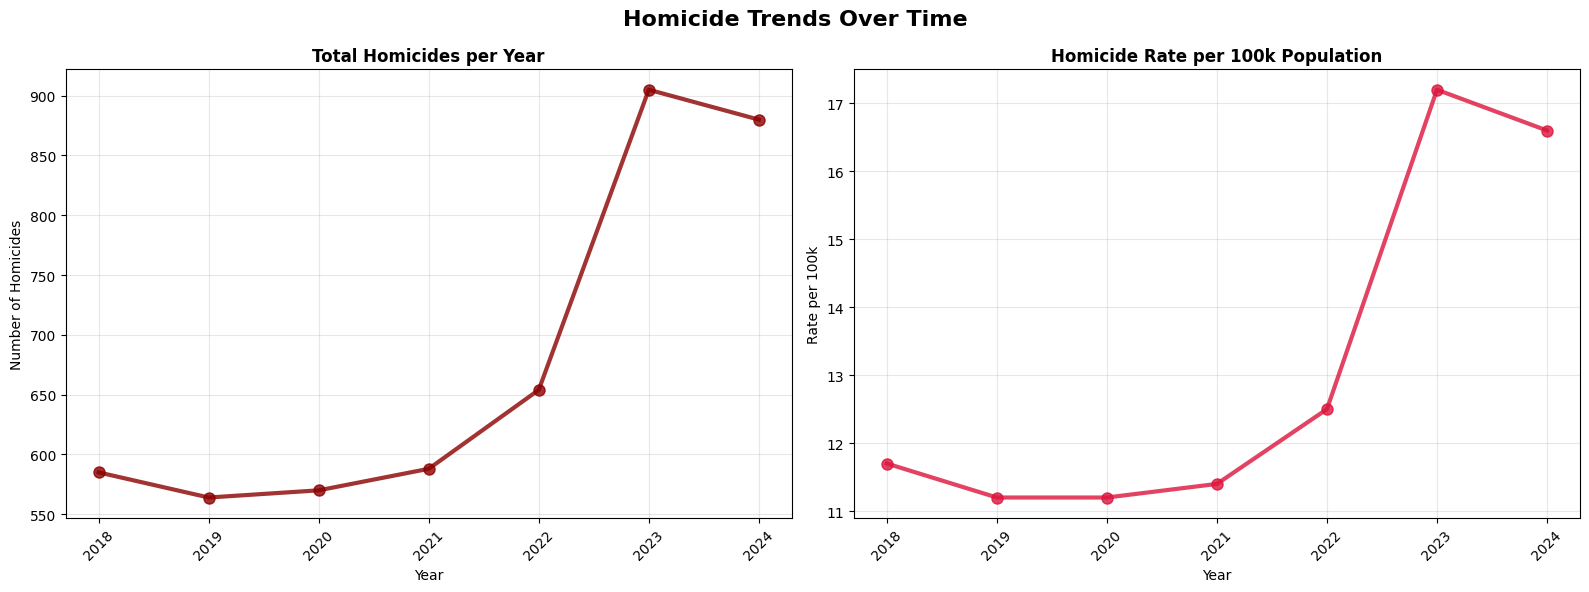


Homicide Year-over-Year Changes:
  Total Homicides: +7.9% average annual change
  Homicide Rate per 100k: +6.9% average annual change

Homicide Peak Years:
  Highest homicide count: 2023 (905 homicides)
  Highest homicide rate: 2023 (17.2 per 100k)

DRUG SEIZURE QUANTITIES


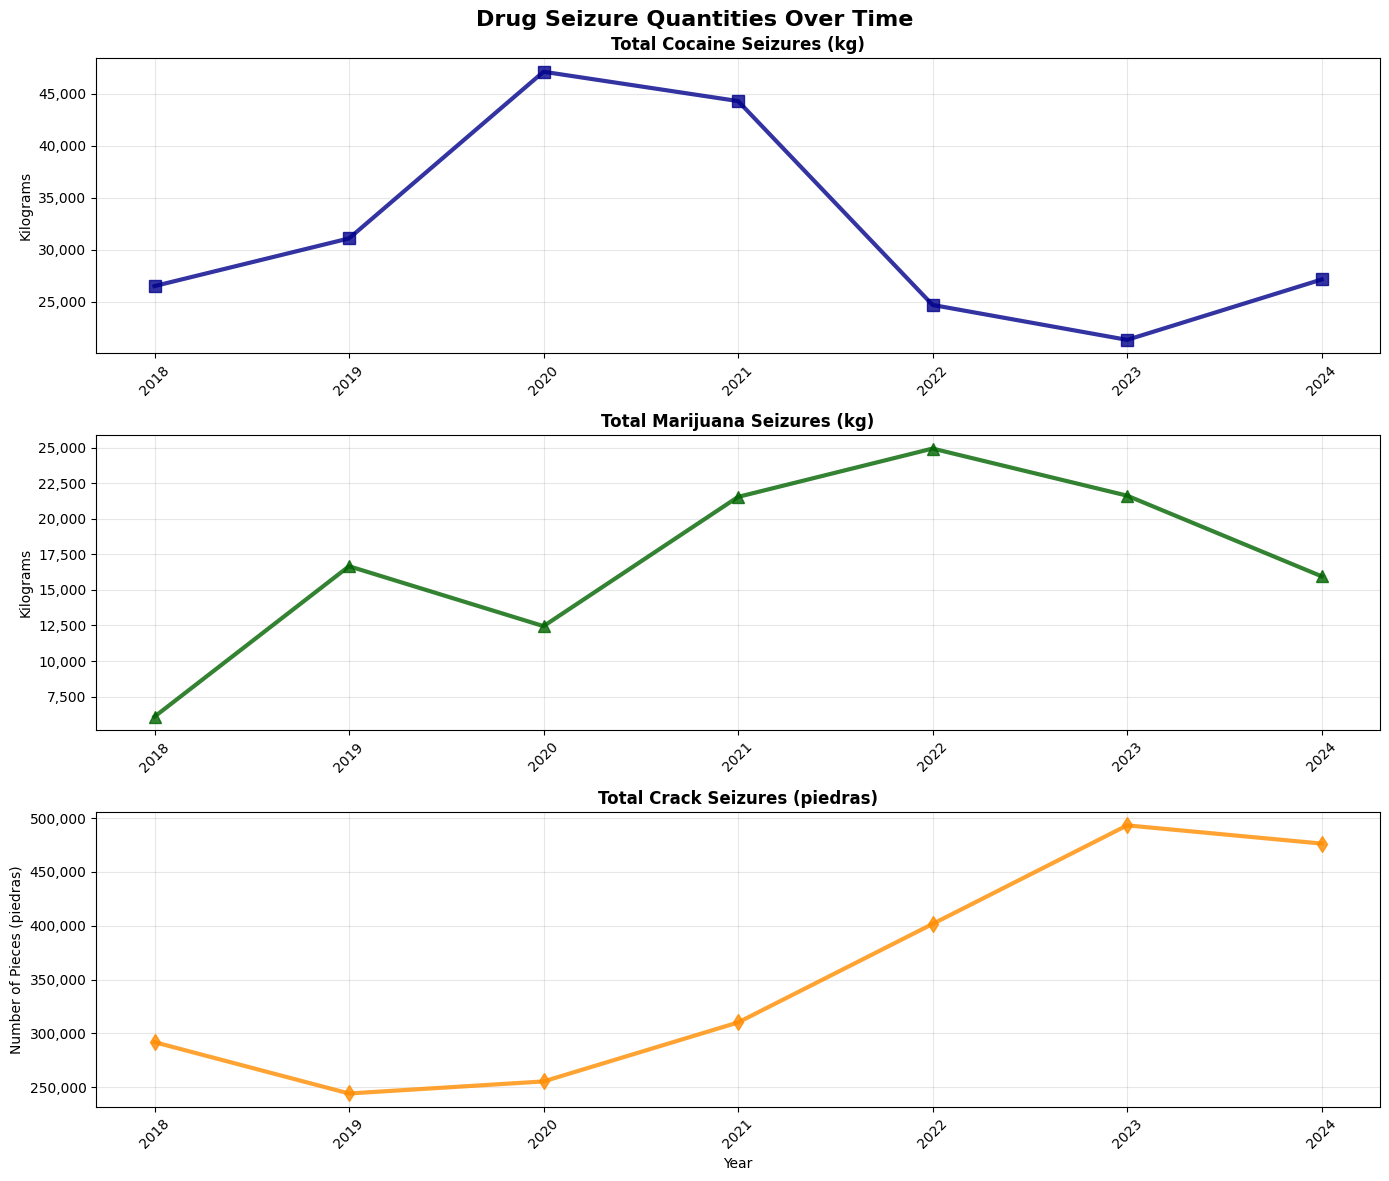


Drug Quantities Year-over-Year Changes:
  Cocaine Seizures (kg): +5.4% average annual change
  Marijuana Seizures (kg): +32.9% average annual change
  Crack Seizures (piedras): +9.8% average annual change

Drug Seizure Peak Years:
  Largest cocaine seizure: 2020 (47,106 kg)
  Largest marijuana seizure: 2022 (24,937 kg)
  Largest crack seizure: 2023 (493,233 pieces)

DRUG SEIZURE EVENTS


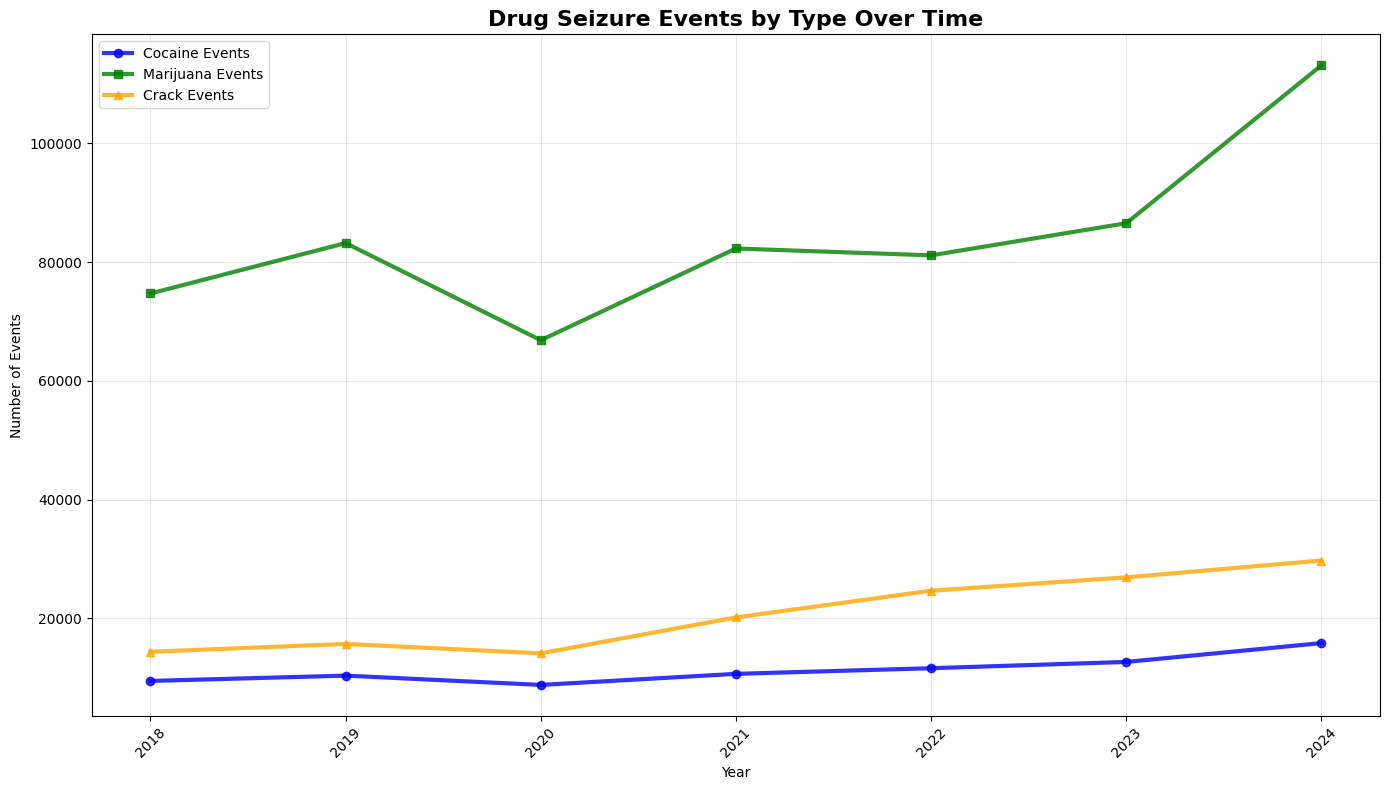


Drug Events Year-over-Year Changes:
  Cocaine Events: +9.8% average annual change
  Marijuana Events: +8.5% average annual change
  Crack Events: +14.0% average annual change

Drug Events Peak Years:
  Most cocaine events: 2024 (15,833 events)
  Most marijuana events: 2024 (113,139 events)
  Most crack events: 2024 (29,743 events)


In [18]:
print("=== TEMPORAL TRENDS ANALYSIS ===")

# Time series aggregations
yearly_trends = merged_df.groupby('year').agg({
    'homicidios_país_año': 'mean',
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum',
    'crack_eventos': 'sum',
    'crack_(piedras)': 'sum'
}).reset_index()

# Fill any NaN values with 0 for cleaner plotting
yearly_trends = yearly_trends.fillna(0)

# ============================================================================
# HOMICIDE TRENDS ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("HOMICIDE TRENDS")
print("="*60)

# Create homicide trends plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Homicide Trends Over Time', fontsize=16, fontweight='bold')

# Total homicides
axes[0].plot(yearly_trends['year'], yearly_trends['homicidios_país_año'], 
             marker='o', linewidth=3, markersize=8, color='darkred', alpha=0.8)
axes[0].set_title('Total Homicides per Year', fontweight='bold')
axes[0].set_ylabel('Number of Homicides')
axes[0].set_xlabel('Year')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Homicide rate
axes[1].plot(yearly_trends['year'], yearly_trends['tasa_100mil_país'], 
             marker='o', linewidth=3, markersize=8, color='crimson', alpha=0.8)
axes[1].set_title('Homicide Rate per 100k Population', fontweight='bold')
axes[1].set_ylabel('Rate per 100k')
axes[1].set_xlabel('Year')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Homicide statistics
print("\nHomicide Year-over-Year Changes:")
homicide_metrics = {
    'homicidios_país_año': 'Total Homicides',
    'tasa_100mil_país': 'Homicide Rate per 100k'
}

for col, label in homicide_metrics.items():
    if col in yearly_trends.columns:
        pct_changes = yearly_trends[col].pct_change().dropna()
        if len(pct_changes) > 0:
            avg_change = pct_changes.mean() * 100
            print(f"  {label}: {avg_change:+.1f}% average annual change")
        else:
            print(f"  {label}: Insufficient data for trend calculation")

# Homicide peak years
print("\nHomicide Peak Years:")
try:
    max_homicides_idx = yearly_trends['homicidios_país_año'].idxmax()
    max_homicides_year = yearly_trends.loc[max_homicides_idx, 'year']
    max_homicides_value = yearly_trends.loc[max_homicides_idx, 'homicidios_país_año']
    print(f"  Highest homicide count: {max_homicides_year} ({max_homicides_value:,.0f} homicides)")
    
    max_rate_idx = yearly_trends['tasa_100mil_país'].idxmax()
    max_rate_year = yearly_trends.loc[max_rate_idx, 'year']
    max_rate_value = yearly_trends.loc[max_rate_idx, 'tasa_100mil_país']
    print(f"  Highest homicide rate: {max_rate_year} ({max_rate_value:.1f} per 100k)")
    
except Exception as e:
    print(f"  Error calculating homicide peaks: {e}")

# ============================================================================
# DRUG QUANTITIES ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("DRUG SEIZURE QUANTITIES")
print("="*60)

# Create drug quantities plots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Drug Seizure Quantities Over Time', fontsize=16, fontweight='bold')

# Cocaine seizures
axes[0].plot(yearly_trends['year'], yearly_trends['cocaína_(kg)'], 
             marker='s', linewidth=3, markersize=8, color='darkblue', alpha=0.8)
axes[0].set_title('Total Cocaine Seizures (kg)', fontweight='bold')
axes[0].set_ylabel('Kilograms')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Marijuana seizures
axes[1].plot(yearly_trends['year'], yearly_trends['marihuana_(kg)'], 
             marker='^', linewidth=3, markersize=8, color='darkgreen', alpha=0.8)
axes[1].set_title('Total Marijuana Seizures (kg)', fontweight='bold')
axes[1].set_ylabel('Kilograms')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Crack seizures (piedras)
axes[2].plot(yearly_trends['year'], yearly_trends['crack_(piedras)'], 
             marker='d', linewidth=3, markersize=8, color='darkorange', alpha=0.8)
axes[2].set_title('Total Crack Seizures (piedras)', fontweight='bold')
axes[2].set_ylabel('Number of Pieces (piedras)')
axes[2].set_xlabel('Year')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# Drug quantities statistics
print("\nDrug Quantities Year-over-Year Changes:")
drug_quantity_metrics = {
    'cocaína_(kg)': 'Cocaine Seizures (kg)',
    'marihuana_(kg)': 'Marijuana Seizures (kg)',
    'crack_(piedras)': 'Crack Seizures (piedras)'
}

for col, label in drug_quantity_metrics.items():
    if col in yearly_trends.columns:
        pct_changes = yearly_trends[col].pct_change().dropna()
        if len(pct_changes) > 0:
            avg_change = pct_changes.mean() * 100
            print(f"  {label}: {avg_change:+.1f}% average annual change")
        else:
            print(f"  {label}: Insufficient data for trend calculation")

# Drug quantities peak years
print("\nDrug Seizure Peak Years:")
try:
    max_cocaine_idx = yearly_trends['cocaína_(kg)'].idxmax()
    max_cocaine_year = yearly_trends.loc[max_cocaine_idx, 'year']
    max_cocaine_value = yearly_trends.loc[max_cocaine_idx, 'cocaína_(kg)']
    print(f"  Largest cocaine seizure: {max_cocaine_year} ({max_cocaine_value:,.0f} kg)")
    
    max_marijuana_idx = yearly_trends['marihuana_(kg)'].idxmax()
    max_marijuana_year = yearly_trends.loc[max_marijuana_idx, 'year']
    max_marijuana_value = yearly_trends.loc[max_marijuana_idx, 'marihuana_(kg)']
    print(f"  Largest marijuana seizure: {max_marijuana_year} ({max_marijuana_value:,.0f} kg)")
    
    max_crack_idx = yearly_trends['crack_(piedras)'].idxmax()
    max_crack_year = yearly_trends.loc[max_crack_idx, 'year']
    max_crack_value = yearly_trends.loc[max_crack_idx, 'crack_(piedras)']
    print(f"  Largest crack seizure: {max_crack_year} ({max_crack_value:,.0f} pieces)")
    

except Exception as e:
    print(f"  Error calculating drug seizure peaks: {e}")

# ============================================================================
# DRUG EVENTS ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("DRUG SEIZURE EVENTS")
print("="*60)

# Create drug events plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.plot(yearly_trends['year'], yearly_trends['cocaína_eventos'], 
        marker='o', linewidth=3, label='Cocaine Events', color='blue', alpha=0.8)
ax.plot(yearly_trends['year'], yearly_trends['marihuana_eventos'], 
        marker='s', linewidth=3, label='Marijuana Events', color='green', alpha=0.8)
ax.plot(yearly_trends['year'], yearly_trends['crack_eventos'], 
        marker='^', linewidth=3, label='Crack Events', color='orange', alpha=0.8)
ax.set_title('Drug Seizure Events by Type Over Time', fontweight='bold', fontsize=16)
ax.set_ylabel('Number of Events')
ax.set_xlabel('Year')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Drug events statistics
print("\nDrug Events Year-over-Year Changes:")
drug_event_metrics = {
    'cocaína_eventos': 'Cocaine Events',
    'marihuana_eventos': 'Marijuana Events',
    'crack_eventos': 'Crack Events'
}

for col, label in drug_event_metrics.items():
    if col in yearly_trends.columns:
        pct_changes = yearly_trends[col].pct_change().dropna()
        if len(pct_changes) > 0:
            avg_change = pct_changes.mean() * 100
            print(f"  {label}: {avg_change:+.1f}% average annual change")
        else:
            print(f"  {label}: Insufficient data for trend calculation")

# Drug events peak years
print("\nDrug Events Peak Years:")
try:
    max_cocaine_events_idx = yearly_trends['cocaína_eventos'].idxmax()
    max_cocaine_events_year = yearly_trends.loc[max_cocaine_events_idx, 'year']
    max_cocaine_events_value = yearly_trends.loc[max_cocaine_events_idx, 'cocaína_eventos']
    print(f"  Most cocaine events: {max_cocaine_events_year} ({max_cocaine_events_value:,.0f} events)")
    
    max_marijuana_events_idx = yearly_trends['marihuana_eventos'].idxmax()
    max_marijuana_events_year = yearly_trends.loc[max_marijuana_events_idx, 'year']
    max_marijuana_events_value = yearly_trends.loc[max_marijuana_events_idx, 'marihuana_eventos']
    print(f"  Most marijuana events: {max_marijuana_events_year} ({max_marijuana_events_value:,.0f} events)")
    
    max_crack_events_idx = yearly_trends['crack_eventos'].idxmax()
    max_crack_events_year = yearly_trends.loc[max_crack_events_idx, 'year']
    max_crack_events_value = yearly_trends.loc[max_crack_events_idx, 'crack_eventos']
    print(f"  Most crack events: {max_crack_events_year} ({max_crack_events_value:,.0f} events)")
    
except Exception as e:
    print(f"  Error calculating drug event peaks: {e}")


#### Correlations

In [22]:
# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

print("\nCorrelations (Homicide Rate vs Drug Metrics):")
correlations = {
    'Cocaine Seizures (kg)': yearly_trends['tasa_100mil_país'].corr(yearly_trends['cocaína_(kg)']),
    'Marijuana Seizures (kg)': yearly_trends['tasa_100mil_país'].corr(yearly_trends['marihuana_(kg)']),
    'Cocaine Events': yearly_trends['tasa_100mil_país'].corr(yearly_trends['cocaína_eventos']),
    'Marijuana Events': yearly_trends['tasa_100mil_país'].corr(yearly_trends['marihuana_eventos']),
    'Crack Events': yearly_trends['tasa_100mil_país'].corr(yearly_trends['crack_eventos'])
}

for metric, corr in correlations.items():
    if not pd.isna(corr):
        strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"  {metric}: {corr:.3f} ({strength} {direction} correlation)")
    else:
        print(f"  {metric}: No correlation data available")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nData Coverage:")
print(f"  Years covered: {yearly_trends['year'].min()} - {yearly_trends['year'].max()}")
print(f"  Total years analyzed: {len(yearly_trends)}")

# Display the yearly trends table
print("\nYearly Trends Summary:")
display_cols = ['year', 'homicidios_país_año', 'tasa_100mil_país', 'cocaína_(kg)', 'marihuana_(kg)', 'cocaína_eventos', 'marihuana_eventos']
yearly_display = yearly_trends[display_cols].copy()
yearly_display.columns = ['Year', 'Total Homicides', 'Rate per 100k', 'Cocaine (kg)', 'Marijuana (kg)', 'Cocaine Events', 'Marijuana Events']

# Round numeric columns for better display
for col in yearly_display.columns:
    if yearly_display[col].dtype in ['float64', 'int64'] and col != 'Year':
        yearly_display[col] = yearly_display[col].round(1)

print(yearly_display.to_string(index=False))


CORRELATION ANALYSIS

Correlations (Homicide Rate vs Drug Metrics):
  Cocaine Seizures (kg): -0.611 (Moderate negative correlation)
  Marijuana Seizures (kg): 0.271 (Weak positive correlation)
  Cocaine Events: 0.845 (Strong positive correlation)
  Marijuana Events: 0.721 (Strong positive correlation)
  Crack Events: 0.859 (Strong positive correlation)

SUMMARY STATISTICS

Data Coverage:
  Years covered: 2018 - 2024
  Total years analyzed: 7

Yearly Trends Summary:
 Year  Total Homicides  Rate per 100k  Cocaine (kg)  Marijuana (kg)  Cocaine Events  Marijuana Events
 2018            585.0           11.7       26519.2          6089.6          9460.0           74712.0
 2019            564.0           11.2       31099.0         16665.1         10354.0           83206.0
 2020            570.0           11.2       47106.3         12453.1          8790.0           66842.0
 2021            588.0           11.4       44289.5         21539.6         10653.0           82289.0
 2022            65

Correlation Matrix:
                      homicidios_país_año  tasa_100mil_país  habitantes_país  \
homicidios_país_año             1.000000          0.998503         0.841889   
tasa_100mil_país                0.998503          1.000000         0.811359   
habitantes_país                 0.841889          0.811359         1.000000   
cocaína_eventos                 0.057546          0.056525         0.056994   
cocaína_(kg)                   -0.014295         -0.014655        -0.007254   
crack_eventos                   0.073460          0.071481         0.079054   
crack_(piedras)                 0.078814          0.077831         0.073447   
marihuana_eventos               0.044112          0.043430         0.042758   
marihuana_(kg)                  0.006452          0.005624         0.013438   

                     cocaína_eventos  cocaína_(kg)  crack_eventos  \
homicidios_país_año         0.057546     -0.014295       0.073460   
tasa_100mil_país            0.056525     -0.014655

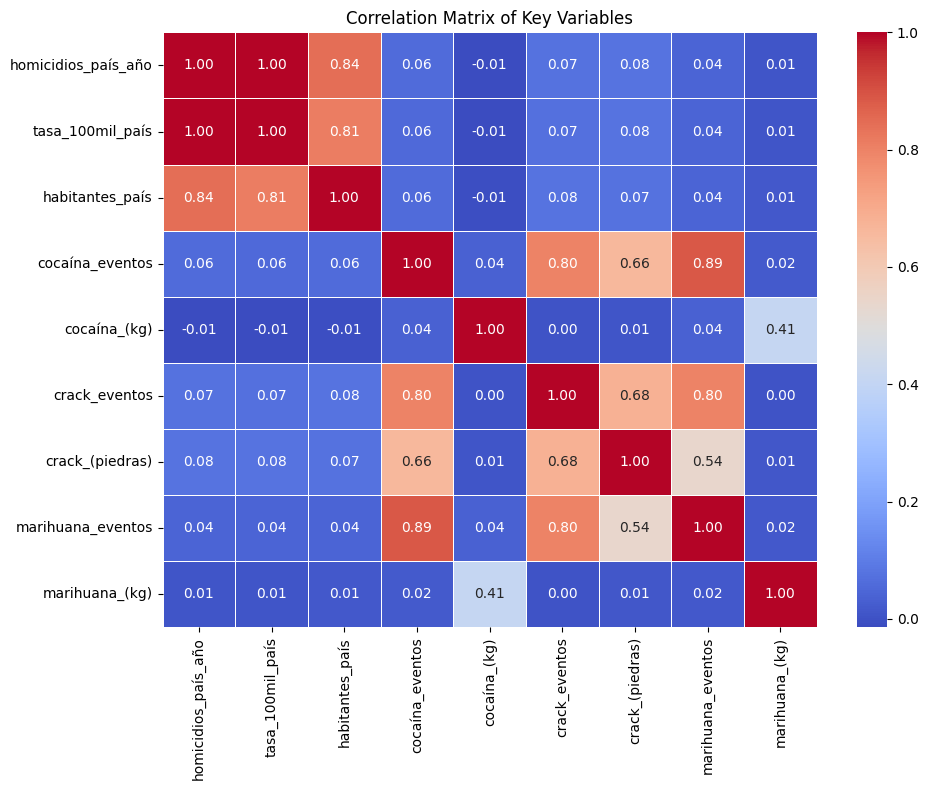

In [23]:

# Select numeric columns for correlation analysis
cols = [
    'homicidios_país_año', 'tasa_100mil_país', 'habitantes_país',
    'cocaína_eventos', 'cocaína_(kg)', 'crack_eventos', 'crack_(piedras)',
    'marihuana_eventos', 'marihuana_(kg)'
]

# Subset the DataFrame
df_corr = merged_df[cols]

# Compute the correlation matrix
corr_matrix = df_corr.corr()

# Display the correlation matrix
print("Correlation Matrix:\n", corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()


#### Geograhy

=== GEOGRAPHIC HOTSPOTS ANALYSIS ===

Geographic Hotspots:

Largest Cocaine Seizures & Events:
  1. Costa Atlántica, Costa Rica: 77,513 kg (Events: 106)
  2. Costa Pacífica, Costa Rica: 55,941 kg (Events: 109)
  3. Puntarenas, Costa Rica: 36,440 kg (Events: 7,674)
  4. Limón, Costa Rica: 24,975 kg (Events: 6,261)
  5. Guanacaste, Costa Rica: 11,268 kg (Events: 8,536)

Largest Marijuana Seizures & Events:
  1. Costa Pacífica, Costa Rica: 69,064 kg (Events: 75)
  2. Puntarenas, Costa Rica: 19,994 kg (Events: 49,111)
  3. Limón, Costa Rica: 12,515 kg (Events: 55,406)
  4. San José, Costa Rica: 5,995 kg (Events: 259,874)
  5. Guanacaste, Costa Rica: 4,549 kg (Events: 46,125)

Largest Crack Seizures & Events:
  1. San José, Costa Rica: 957,692 piedras (Events: 63,029)
  2. Alajuela, Costa Rica: 436,356 piedras (Events: 29,117)
  3. Puntarenas, Costa Rica: 244,743 piedras (Events: 13,163)
  4. Cartago, Costa Rica: 242,564 piedras (Events: 12,641)
  5. Limón, Costa Rica: 231,696 piedras (Even

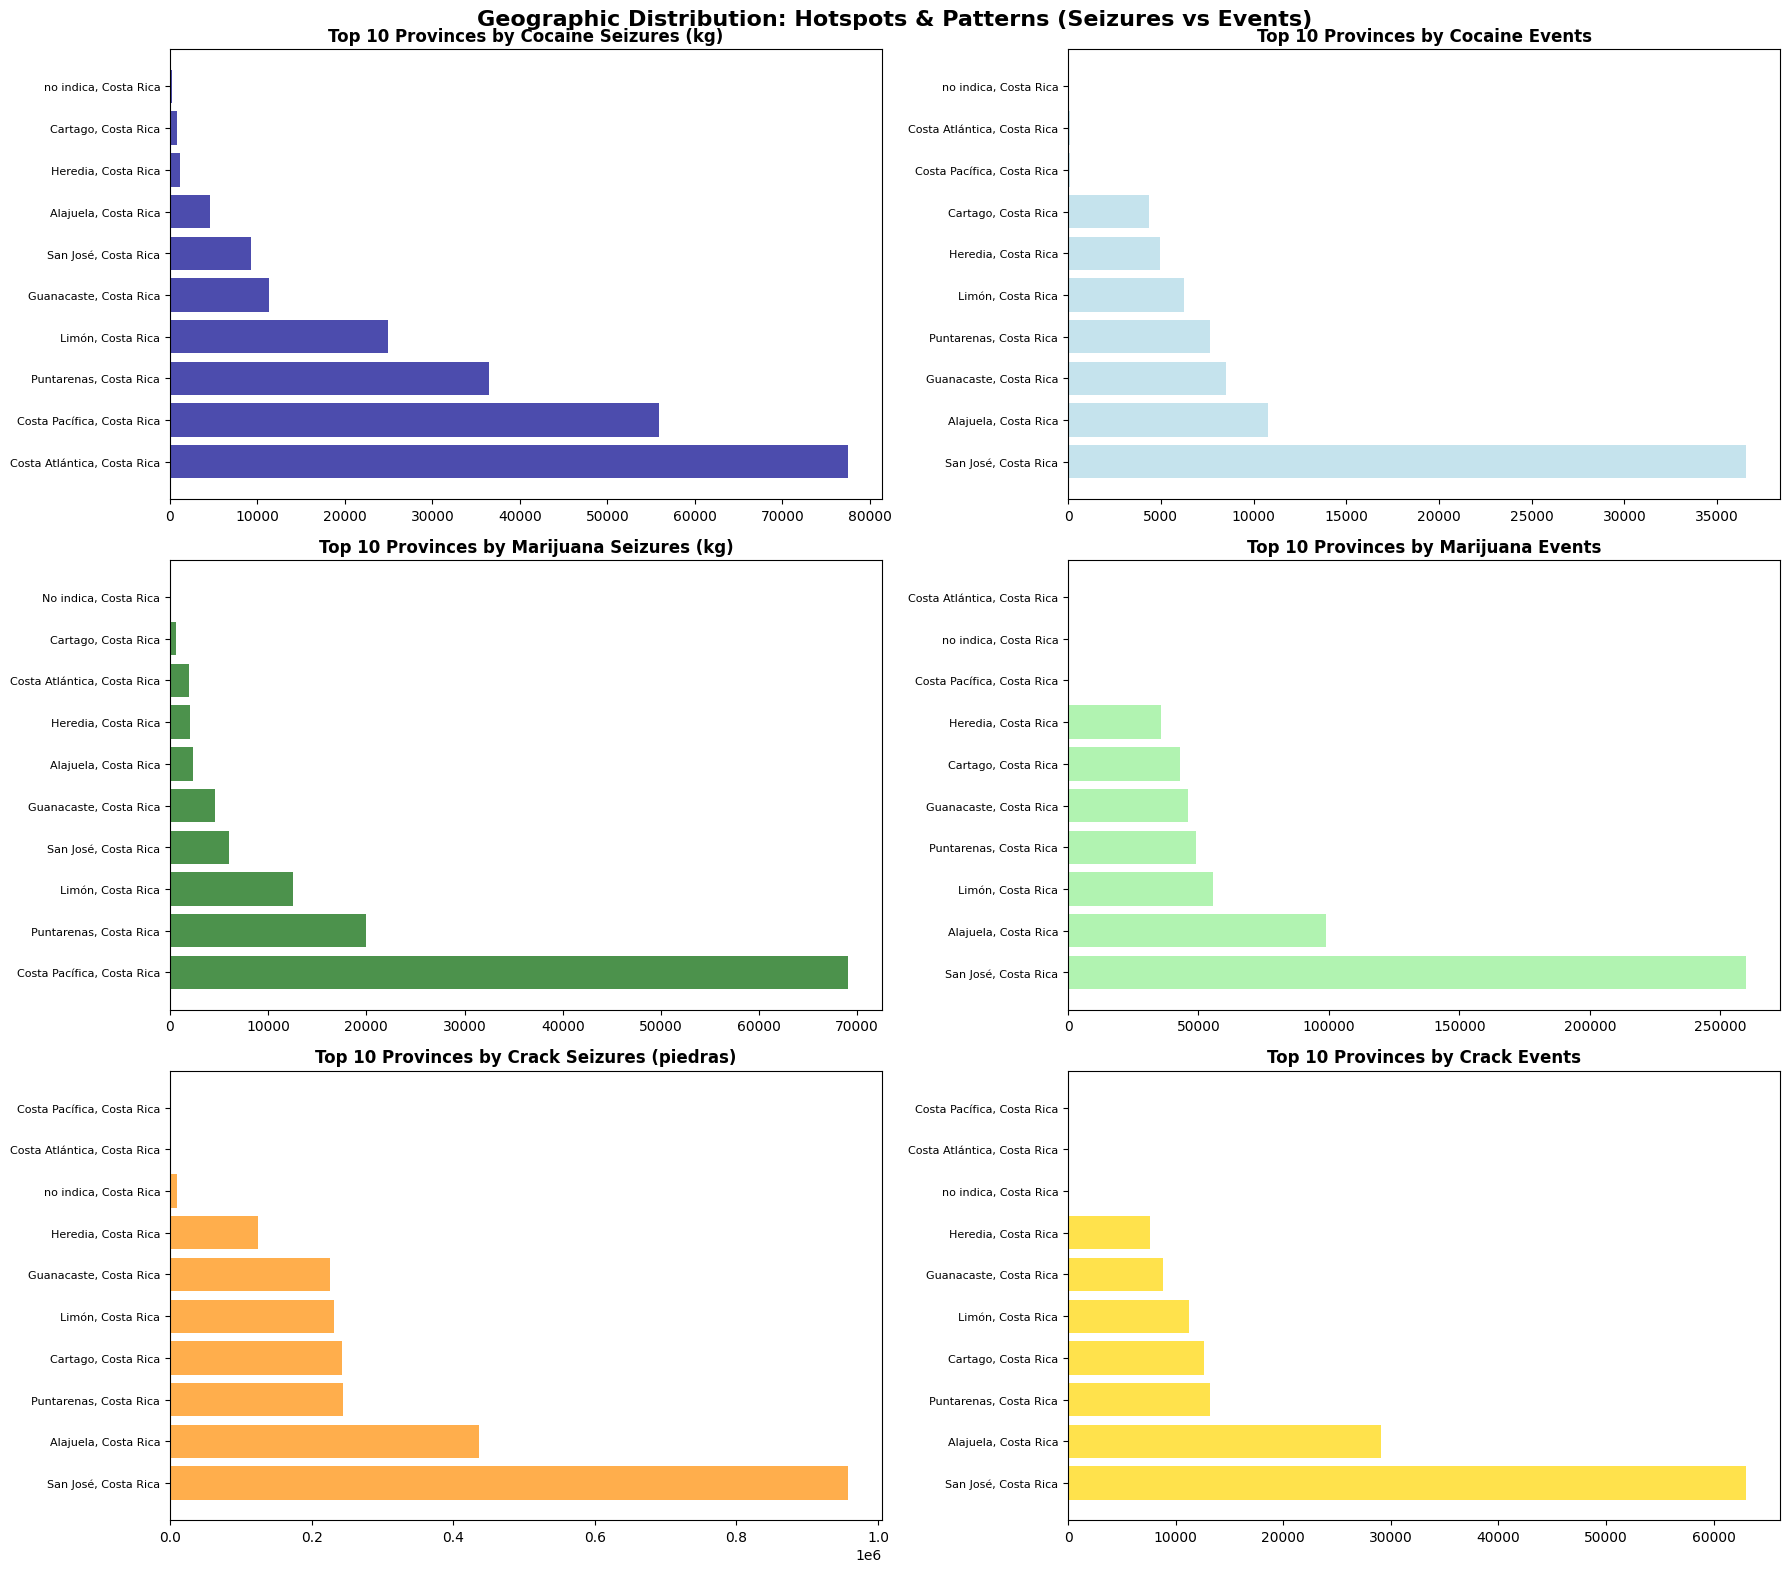

In [24]:
print("=== GEOGRAPHIC HOTSPOTS ANALYSIS ===")

# Country-level analysis
country_analysis = merged_df.groupby('país').agg({
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum',
    'crack_eventos': 'sum',  # Added crack eventos
    'habitantes_país': 'mean',
    'crack_(piedras)': 'sum'
}).round(2)

# Province-level analysis (top 10 by different metrics)
province_analysis = merged_df.groupby(['país', 'provincia']).agg({
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum',
    'crack_eventos': 'sum',
    'crack_(piedras)': 'sum'
}).reset_index()

# Create geographic visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('Geographic Distribution: Hotspots & Patterns (Seizures vs Events)', fontsize=16, fontweight='bold')

# --- COCAINE ---
# Top provinces by cocaine seizures
top_cocaine_provinces = province_analysis.nlargest(10, 'cocaína_(kg)')
axes[0,0].barh(range(len(top_cocaine_provinces)), top_cocaine_provinces['cocaína_(kg)'],
               color='darkblue', alpha=0.7)
axes[0,0].set_yticks(range(len(top_cocaine_provinces)))
axes[0,0].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_cocaine_provinces.iterrows()],
                          fontsize=8)
axes[0,0].set_title('Top 10 Provinces by Cocaine Seizures (kg)', fontweight='bold')

# Top provinces by cocaine events
top_cocaine_events = province_analysis.nlargest(10, 'cocaína_eventos')
axes[0,1].barh(range(len(top_cocaine_events)), top_cocaine_events['cocaína_eventos'],
               color='lightblue', alpha=0.7)
axes[0,1].set_yticks(range(len(top_cocaine_events)))
axes[0,1].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_cocaine_events.iterrows()],
                          fontsize=8)
axes[0,1].set_title('Top 10 Provinces by Cocaine Events', fontweight='bold')

# --- MARIJUANA ---
# Top provinces by marijuana seizures
top_marijuana_provinces = province_analysis.nlargest(10, 'marihuana_(kg)')
axes[1,0].barh(range(len(top_marijuana_provinces)), top_marijuana_provinces['marihuana_(kg)'],
               color='darkgreen', alpha=0.7)
axes[1,0].set_yticks(range(len(top_marijuana_provinces)))
axes[1,0].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_marijuana_provinces.iterrows()],
                          fontsize=8)
axes[1,0].set_title('Top 10 Provinces by Marijuana Seizures (kg)', fontweight='bold')

# Top provinces by marijuana events
top_marijuana_events = province_analysis.nlargest(10, 'marihuana_eventos')
axes[1,1].barh(range(len(top_marijuana_events)), top_marijuana_events['marihuana_eventos'],
               color='lightgreen', alpha=0.7)
axes[1,1].set_yticks(range(len(top_marijuana_events)))
axes[1,1].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_marijuana_events.iterrows()],
                          fontsize=8)
axes[1,1].set_title('Top 10 Provinces by Marijuana Events', fontweight='bold')

# --- CRACK ---
# Top provinces by crack seizures
top_crack_provinces = province_analysis.nlargest(10, 'crack_(piedras)')
axes[2,0].barh(range(len(top_crack_provinces)), top_crack_provinces['crack_(piedras)'],
               color='darkorange', alpha=0.7)   
axes[2,0].set_yticks(range(len(top_crack_provinces)))
axes[2,0].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_crack_provinces.iterrows()],
                          fontsize=8)
axes[2,0].set_title('Top 10 Provinces by Crack Seizures (piedras)', fontweight='bold')

# Top provinces by crack events
top_crack_events = province_analysis.nlargest(10, 'crack_eventos')
axes[2,1].barh(range(len(top_crack_events)), top_crack_events['crack_eventos'],
               color='gold', alpha=0.7)
axes[2,1].set_yticks(range(len(top_crack_events)))
axes[2,1].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_crack_events.iterrows()],
                          fontsize=8)
axes[2,1].set_title('Top 10 Provinces by Crack Events', fontweight='bold')

plt.tight_layout()

# Print geographic information
print("\nGeographic Hotspots:")

print("\nLargest Cocaine Seizures & Events:")
for i, (_, row) in enumerate(province_analysis.nlargest(5, 'cocaína_(kg)').iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['cocaína_(kg)']:,.0f} kg (Events: {row['cocaína_eventos']:,.0f})")

print("\nLargest Marijuana Seizures & Events:")
for i, (_, row) in enumerate(province_analysis.nlargest(5, 'marihuana_(kg)').iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['marihuana_(kg)']:,.0f} kg (Events: {row['marihuana_eventos']:,.0f})")
    
print("\nLargest Crack Seizures & Events:")
for i, (_, row) in enumerate(province_analysis.nlargest(5, 'crack_(piedras)').iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['crack_(piedras)']:,.0f} piedras (Events: {row['crack_eventos']:,.0f})")  

# Calculate concentration metrics
total_cocaine = merged_df['cocaína_(kg)'].sum()
total_marijuana = merged_df['marihuana_(kg)'].sum()
total_crack = merged_df['crack_(piedras)'].sum()
total_cocaine_events = merged_df['cocaína_eventos'].sum()
total_marijuana_events = merged_df['marihuana_eventos'].sum()
total_crack_events = merged_df['crack_eventos'].sum()

print(f"\nConcentration Analysis:")
print(f"Top 5 provinces account for:")
print(f"- {province_analysis.nlargest(5, 'cocaína_(kg)')['cocaína_(kg)'].sum()/total_cocaine*100:.1f}% of cocaine seizures")
print(f"- {province_analysis.nlargest(5, 'cocaína_eventos')['cocaína_eventos'].sum()/total_cocaine_events*100:.1f}% of cocaine events")
print(f"- {province_analysis.nlargest(5, 'marihuana_(kg)')['marihuana_(kg)'].sum()/total_marijuana*100:.1f}% of marijuana seizures")
print(f"- {province_analysis.nlargest(5, 'marihuana_eventos')['marihuana_eventos'].sum()/total_marijuana_events*100:.1f}% of marijuana events")
print(f"- {province_analysis.nlargest(5, 'crack_(piedras)')['crack_(piedras)'].sum()/total_crack*100:.1f}% of crack seizures")
print(f"- {province_analysis.nlargest(5, 'crack_eventos')['crack_eventos'].sum()/total_crack_events*100:.1f}% of crack events")

### Takeaways


- (Obvious) Homicides are mostly related to population size, not drug seizures.

- Drug seizures (events) often happen together but don’t strongly connect to homicides.

- The quantity of drugs seized (kg/piedras) has little impact on homicides or other drug seizures.

- Desirable: have homicide rates for provinces from 2018 or before, have previous data for seizures. 

What else can be done with the data at hand?

spatial viz (seizures by prov), 
derived indicators: seizure efficiency by quant of drugs, intensity by pop (national/provincial/cantonal),
uML: clustering to classify prov/cantons by seizures and events, 
if you want to estimate or explain homicide patterns then define a target variable (Y): Homicide counts or homicide rate (per 100,000 people) at the national, provincial or cantonal level, have other predictors soc, eco, gov etc

## Data visualizations focusing on provinces

In [26]:
seizures_df

,País,Provincia,Cantón,Distrito,Cocaína Eventos,Cocaína (kg),Crack Eventos,Crack (piedras),Marihuana Eventos,Marihuana (kg),year
0,Costa Rica,Alajuela,Alajuela,Alajuela,161.0,0.05825,370.0,6644.400000,769.0,14.33302,2019
1,Costa Rica,Alajuela,Alajuela,San José,144.0,0.70250,289.0,10406.666667,478.0,1.45790,2019
2,Costa Rica,Alajuela,Alajuela,Carrizal,9.0,0.00625,9.0,204.000000,21.0,0.03950,2019
3,Costa Rica,Alajuela,Alajuela,San Antonio,34.0,0.32975,60.0,913.333333,449.0,1.06203,2019
4,Costa Rica,Alajuela,Alajuela,Guácima,51.0,0.93440,155.0,5812.333333,450.0,2.08663,2019
...,...,...,...,...,...,...,...,...,...,...,...
3394,Costa Rica,San José,León Cortés Castro,San Antonio,1.0,0.00000,1.0,3.000000,8.0,0.04015,2024
3395,Costa Rica,Costa Pacífica,Costa Pacífica,Costa Pacífica,15.0,10498.00000,0.0,0.000000,9.0,5610.29890,2024
3396,Costa Rica,Costa Atlántica,Costa Atlántica,Costa Atlántica,21.0,4882.00000,0.0,0.000000,7.0,2.10000,2024
3397,Costa Rica,no indica,no indica,no indica,0.0,0.00000,0.0,0.000000,0.0,0.00000,2024


In [31]:
## Plotting multi-line graphs for each substance (in kg or stones), with one line representing each province

# Removing any NAs that might exist in our columns of interest
df_clean = seizures_df.dropna(subset=["Provincia", "year", "Cocaína (kg)", "Crack (piedras)", "Marihuana (kg)"])

# Grouping the interest columns by year and province and summing the total values 
df_grouped = df_clean.groupby(["Provincia", "year"], as_index=False)[
    ["Cocaína (kg)", "Crack (piedras)", "Marihuana (kg)"]
].sum()
df_grouped

,Provincia,year,Cocaína (kg),Crack (piedras),Marihuana (kg)
0,Alajuela,2018,887.158630,66829.022222,94.816724
1,Alajuela,2019,90.577410,54488.666667,73.811320
2,Alajuela,2020,457.912990,50252.733333,1842.589290
3,Alajuela,2021,960.798350,47298.933333,50.716120
4,Alajuela,2022,77.173108,69940.966667,82.919196
...,...,...,...,...,...
63,San José,2024,1654.655820,188401.013333,1394.291350
64,no indica,2018,0.022500,147.000000,0.648850
65,no indica,2019,17.416750,9260.333333,5.065800
66,no indica,2020,177.000000,0.000000,0.000000


In [34]:
# Removing the lines where the province is not specified ("no indica", "No indica" o "No Indica")
df_grouped = df_grouped[df_grouped["Provincia"] != "no indica"]
df_grouped = df_grouped[df_grouped["Provincia"] != "No indica"]
df_grouped = df_grouped[df_grouped["Provincia"] != "No Indica"]
df_grouped

,Provincia,year,Cocaína (kg),Crack (piedras),Marihuana (kg)
0,Alajuela,2018,887.158630,66829.022222,94.816724
1,Alajuela,2019,90.577410,54488.666667,73.811320
2,Alajuela,2020,457.912990,50252.733333,1842.589290
3,Alajuela,2021,960.798350,47298.933333,50.716120
4,Alajuela,2022,77.173108,69940.966667,82.919196
...,...,...,...,...,...
59,San José,2020,2418.843690,96195.066667,115.050930
60,San José,2021,479.142470,140841.910000,118.381800
61,San José,2022,808.911217,138193.000000,2284.790231
62,San José,2023,395.100690,191456.200000,281.329450


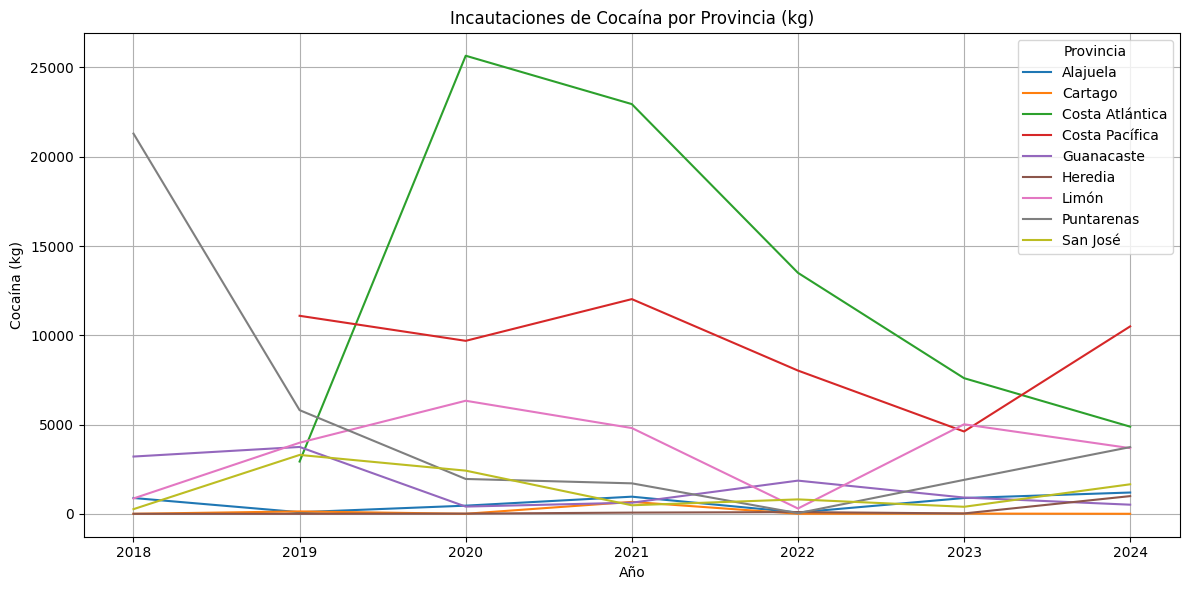

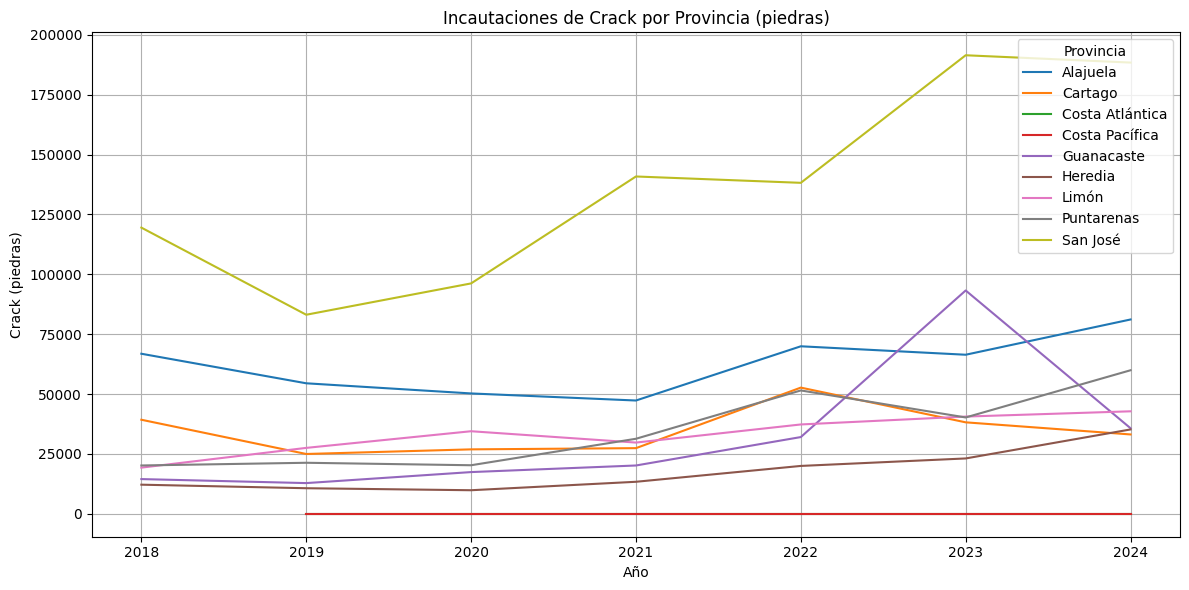

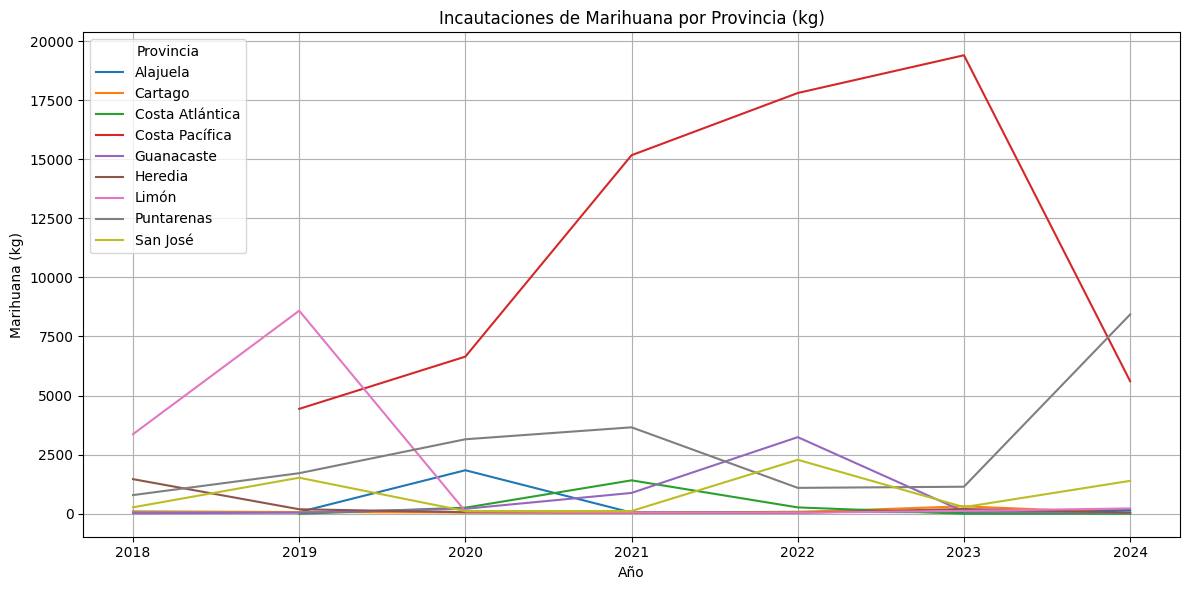

In [41]:
# Defining function to plot one graph per substance 
def plot_line_graph(column, title, ylabel):
    plt.figure(figsize=(12, 6))
    for provincia in df_grouped["Provincia"].unique():
        data = df_grouped[df_grouped["Provincia"] == provincia]
        plt.plot(data["year"], data[column], label=provincia)
    plt.title(title)
    plt.xlabel("Año")
    plt.ylabel(ylabel)
    plt.legend(title="Provincia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting the graphs for each substance
plot_line_graph("Cocaína (kg)", "Incautaciones de Cocaína por Provincia (kg)", "Cocaína (kg)")
plot_line_graph("Crack (piedras)", "Incautaciones de Crack por Provincia (piedras)", "Crack (piedras)")
plot_line_graph("Marihuana (kg)", "Incautaciones de Marihuana por Provincia (kg)", "Marihuana (kg)")

In [55]:
## Now, I'll work on an analysis on the seizures by ports. This data in is the tab 12 of the seizures spreadsheet

# Loading the seizures data from the specified sheet (I'm reading it directly from the excel saved in my computer, so you should replace the path when reproducing)
seizures_ports_df = pd.read_excel('/Users/joseeduardo/Documents/InSight Crime/Control_de_la_Oferta_ODS_SW1.xlsx', sheet_name='12', header=1)
seizures_ports_df

,Terminal Portuaria,Marihuana (kg),Cocaína (kg),Año
0,Muelle Golfito,1162.5000,200.000,2024.0
1,APM Terminals,0.0000,3612.000,2024.0
2,APM Terminals,0.0000,4847.000,2023.0
3,Terminal Gastón Kogan. Moín JAPDEVA,0.0148,801.165,2023.0
4,Muelle Caldera,0.0000,209.400,2023.0
5,Muelle Golfito,3699.4950,184.000,2023.0
6,APM Terminals,0.0000,2929.836,2022.0
7,Terminal Gastón Kogan. Moín JAPDEVA,0.0000,631.000,2022.0
8,APM Terminals,0.0000,8762.000,2021.0
9,Terminal Gastón Kogan. Moín JAPDEVA,0.0000,7254.000,2021.0


In [56]:
# The column Año is showing data like 2023.0, so we need to convert it to int
seizures_ports_df['Año'] = seizures_ports_df['Año'].astype('Int64')
seizures_ports_df = seizures_ports_df.dropna()
seizures_ports_df

,Terminal Portuaria,Marihuana (kg),Cocaína (kg),Año
0,Muelle Golfito,1162.5000,200.000,2024
1,APM Terminals,0.0000,3612.000,2024
2,APM Terminals,0.0000,4847.000,2023
3,Terminal Gastón Kogan. Moín JAPDEVA,0.0148,801.165,2023
4,Muelle Caldera,0.0000,209.400,2023
5,Muelle Golfito,3699.4950,184.000,2023
6,APM Terminals,0.0000,2929.836,2022
7,Terminal Gastón Kogan. Moín JAPDEVA,0.0000,631.000,2022
8,APM Terminals,0.0000,8762.000,2021
9,Terminal Gastón Kogan. Moín JAPDEVA,0.0000,7254.000,2021


In [63]:
import unicodedata

def limpar_texto(texto):
    if isinstance(texto, str):
        texto = texto.strip()  # remove espaços extras
        texto = unicodedata.normalize('NFKD', texto)  # remove acentos
        texto = texto.encode('ASCII', 'ignore').decode('utf-8')  # remove caracteres especiais
        return texto
    return texto

seizures_ports_df['Terminal Portuaria'] = seizures_ports_df['Terminal Portuaria'].apply(limpar_texto)

/var/folders/r6/5x15py7x16s1k88rwqp8v10w0000gn/T/ipykernel_35449/4253539656.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seizures_ports_df['Terminal Portuaria'] = seizures_ports_df['Terminal Portuaria'].apply(limpar_texto)


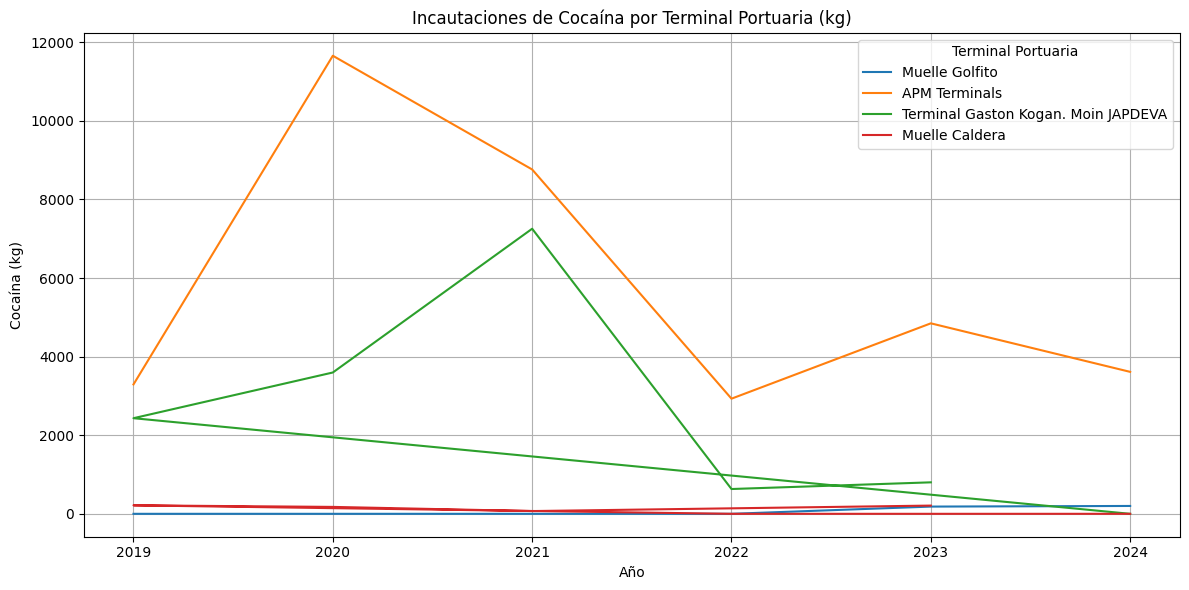

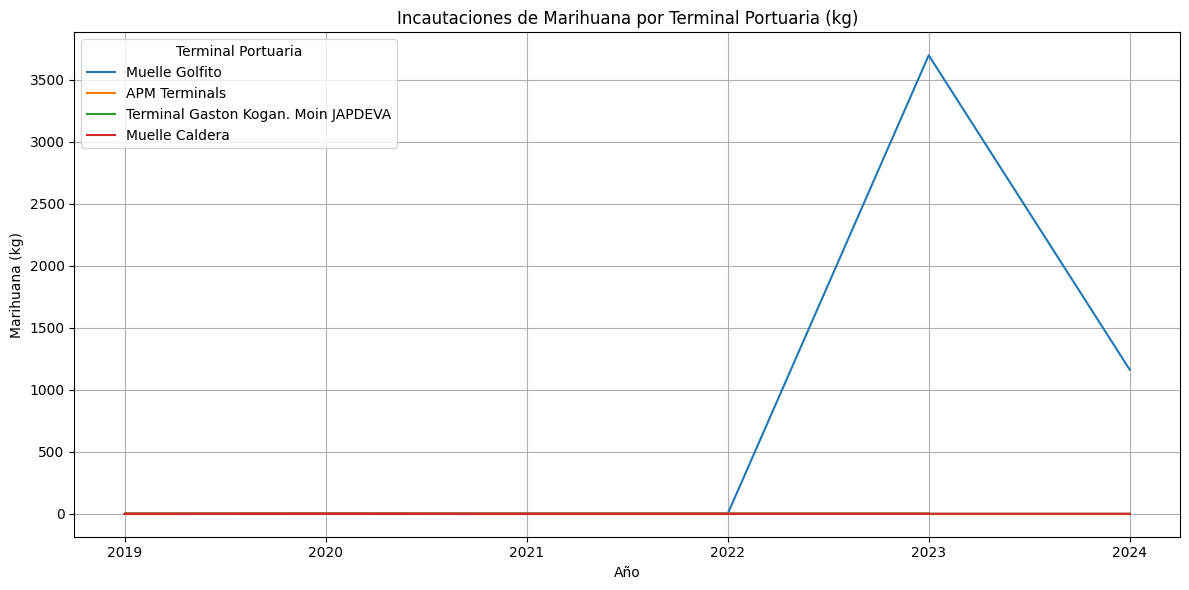

In [64]:
# Defining function to plot one multi-line graph for each substance
def plot_line_graph2(column, title, ylabel):
    plt.figure(figsize=(12, 6))
    for porto in seizures_ports_df["Terminal Portuaria"].unique():
        data = seizures_ports_df[seizures_ports_df["Terminal Portuaria"] == porto]
        plt.plot(data["Año"], data[column], label=porto)
    plt.title(title)
    plt.xlabel("Año")
    plt.ylabel(ylabel)
    plt.legend(title="Terminal Portuaria")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_line_graph2("Cocaína (kg)", "Incautaciones de Cocaína por Terminal Portuaria (kg)", "Cocaína (kg)")
plot_line_graph2("Marihuana (kg)", "Incautaciones de Marihuana por Terminal Portuaria (kg)", "Marihuana (kg)")